Идея этого этапа работы в использовании autoencoder совместно с GAN.

Мой план предобучить autoencoder на хороших пирожках (без матов и непонятных слов их оказывается около 1789) чтобы он научился вычленять и восстанавливать смысл стиха.

Далее построить GAN с такими генератором и дискриминатором:

**generator**: (noise -> dense(latent size) -> decoder(trainable = False)) = sample пирожок

**discriminator**: (verse -> encoder(trainable = False) -> dense(1)) = пирожок / не пирожок

Ход работы ниже..

Теперь к проблемам :(

Запланированную архитектуру в коде мне удалось построить, однако результат оказался плохим.

Я начал дебажить и понял, что мой autoencoder очень плохо восстанавливает предложение по входному образцу. Много повторений и бессмысленных слов. Я прогнал его на большом числе эпох, но он застревает на loss=0.15 и крутится возле этой отметки, не улучшаясь. Можно увидеть ниже.

**Роман Николаевич**, посоветуйте, пожалуйста, что можно сделать?

In [105]:
import collections
import nltk
import os
import numpy as np

Для работы понадобится скачать в папку data предобученный glove файл для русского языка

https://www.kaggle.com/tunguz/russian-glove/downloads/russian-glove.zip/1

используем команды ниже

In [477]:
!mkdir -p data

In [ ]:
!curl -L https://www.dropbox.com/s/px2srte22xbq2pu/multilingual_embeddings.ru?dl=0 > data/multilingual_embeddings.ru

In [478]:
def load_glove_vectors(glove_file, embed_size=300):
    words = [
        "PAD",
        "UNK"]
    vects = [
        np.zeros((embed_size)), # PAD
        np.random.uniform(-1, 1, embed_size)] # UNK

    fglove = open(glove_file, "rb")
    for line in fglove:
        cols = line.strip().split()
        word = cols[0].decode('utf-8')
        vect = np.array([float(v) for v in cols[1:]])
        words.append(word)
        vects.append(vect)

    vocab = {w: i for i, w in enumerate(words)}
    return words, vocab, np.array(vects)

In [479]:
words, vocab, embeddings = load_glove_vectors("data/multilingual_embeddings.ru")

In [480]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="data/multilingual_embeddings.ru", word2vec_output_file="data/gensim_glove_vectors.txt")

(63068, 300)

In [481]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("data/gensim_glove_vectors.txt", binary=False)

In [482]:
glove_model.most_similar("и")

[('оборачиваетесь', 0.7298823595046997),
 ('а', 0.7228611707687378),
 ('черно', 0.654677152633667),
 ('обеспеченные', 0.6393757462501526),
 ('поднимаются', 0.6386812925338745),
 ('мерцающее', 0.6307729482650757),
 ('разбираем', 0.6296200752258301),
 ('маршировать', 0.6277832984924316),
 ('поступая', 0.6192404627799988),
 ('повторяли', 0.6133629679679871)]

In [483]:
glove_model.similar_by_vector(embeddings[vocab["и"]])[0][0]

'и'

In [484]:
embeddings.shape

(63070, 300)

In [485]:
vocab["и"]

13027

In [486]:
words[13027]

'и'

In [487]:
def safe_word2id(word, vocab):
    return vocab["UNK"] if vocab.get(word) == None else vocab[word]

In [488]:
good_sentences = np.genfromtxt("data/good.txt", delimiter="\t")

In [495]:
def tokens2index(tokens_vectors, seq_len = SEQUENCE_LEN):
    windex_vectors = [[safe_word2id(w, vocab) for w in s] for s in tokens_vectors]
    sequence.pad_sequences(windex_vectors, seq_len)

def index2vectors(index_vectors):
    return embeddings[index_vectors.astype(int)]

def vectors2tokens(vectors):
    for sent in vectors:
        print(" ".join([
            glove_model.similar_by_vector(word_vect)[0][0] if sum(word_vect) != 0 else "" for word_vect in sent]))

In [496]:
vectors2tokens(index2vectors(good_sentences[0:3]))

нет в шоколаде шоколада давно нет мяса в пластики становится чуть чуть тревожно а вдруг и в людях нет людей
 я ненавижу вас так долго что в принципе уже забыл и почему вас ненавижу и кто вы собственно такой
     подумай атомы вселенной пластики в состав тебя могли на что нибудь другое намного лучшее пойти


Модель автокодировщика принимает последовательность GloVe-векторов слов и обучается порождать другую последовательность, похожую на входную. LSTM-кодировщик сжимает последовательность в контекстный вектор фиксированной длины, по которой LSTM-декодер реконструирует исходную последовательность.

In [497]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function
from __future__ import absolute_import
from __future__ import unicode_literals
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input
from keras.layers.core import RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing import sequence
import collections
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt
from time import gmtime, strftime

In [498]:
# msin
def compute_cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

In [500]:
# split sentences into training and test
train_size = 0.7
Xtrain, Xtest = train_test_split(good_sentences, train_size=train_size)
print("number of sentences: ", len(good_sentences))
print(Xtrain.shape, Xtest.shape)

number of sentences:  1789
(1252, 20) (537, 20)


In [509]:
def sentence_generator(X, embeddings, batch_size):
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size: (bid + 1) * batch_size]
            Xbatch = index2vectors(X[sids, :])
            yield Xbatch, Xbatch

In [502]:
embeddings.shape

(63070, 300)

In [503]:
Xtrain.shape

(1252, 20)

In [504]:
Xtest.shape

(537, 20)

In [510]:
# define training and test generators
BATCH_SIZE = 64
train_gen = sentence_generator(Xtrain, embeddings, BATCH_SIZE)
test_gen = sentence_generator(Xtest, embeddings, BATCH_SIZE)

In [506]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import unicode_literals
from time import gmtime, strftime

In [588]:
# define autoencoder network
EMBED_SIZE = 300
LATENT_SIZE = 512

inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum",
                        name="encoder_lstm")(inputs)

decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True),
                        merge_mode="sum",
                        name="decoder_lstm")(decoded)

autoencoder = Model(inputs, decoded)

autoencoder.compile(optimizer="sgd", loss="mse")

In [534]:
# train
NUM_EPOCHS = 200
DATA_DIR = "data"

num_train_steps = len(Xtrain) // BATCH_SIZE
num_test_steps = len(Xtest) // BATCH_SIZE

checkpoint = ModelCheckpoint(
    filepath=os.path.join(DATA_DIR, "sent-thoughts-autoencoder.h5"),
    save_best_only=True)

history = autoencoder.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=NUM_EPOCHS,
                                    validation_data=test_gen,
                                    validation_steps=num_test_steps,
                                    callbacks=[checkpoint])

Epoch 1/50
19/19 [==============================] - 11s 595ms/step - loss: 0.1520 - val_loss: 0.1533
Epoch 2/50
19/19 [==============================] - 11s 587ms/step - loss: 0.1530 - val_loss: 0.1534
Epoch 3/50
19/19 [==============================] - 11s 581ms/step - loss: 0.1521 - val_loss: 0.1539
Epoch 4/50
19/19 [==============================] - 11s 588ms/step - loss: 0.1511 - val_loss: 0.1530
Epoch 5/50
19/19 [==============================] - 11s 599ms/step - loss: 0.1523 - val_loss: 0.1510
Epoch 6/50
19/19 [==============================] - 11s 586ms/step - loss: 0.1517 - val_loss: 0.1521
Epoch 7/50
19/19 [==============================] - 11s 586ms/step - loss: 0.1528 - val_loss: 0.1543
Epoch 8/50
19/19 [==============================] - 11s 586ms/step - loss: 0.1517 - val_loss: 0.1538
Epoch 9/50
19/19 [==============================] - 11s 587ms/step - loss: 0.1531 - val_loss: 0.1511
Epoch 10/50
19/19 [==============================] - 11s 601ms/step - loss: 0.1515 - val_lo

In [582]:
# extract encoder model
encoder = Model(autoencoder.input, autoencoder.get_layer("encoder_lstm").output)

In [589]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20, 300)           0         
_________________________________________________________________
encoder_lstm (Bidirectional) (None, 512)               3330048   
_________________________________________________________________
repeater (RepeatVector)      (None, 20, 512)           0         
_________________________________________________________________
decoder_lstm (Bidirectional) (None, 20, 300)           1951200   
Total params: 5,281,248
Trainable params: 5,281,248
Non-trainable params: 0
_________________________________________________________________


In [590]:
encoded_input = Input(shape=(LATENT_SIZE,))

deco = autoencoder.get_layer("repeater")(encoded_input)
deco = autoencoder.get_layer("decoder_lstm")(deco)

# create the decoder model
decoder = Model(encoded_input, deco)

In [591]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 512)               0         
_________________________________________________________________
repeater (RepeatVector)      (None, 20, 512)           0         
_________________________________________________________________
decoder_lstm (Bidirectional) (None, 20, 300)           1951200   
Total params: 1,951,200
Trainable params: 1,951,200
Non-trainable params: 0
_________________________________________________________________


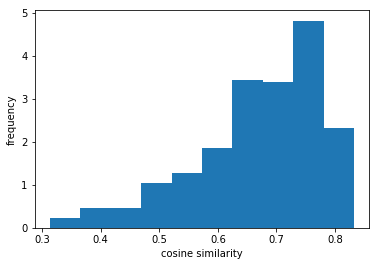

In [536]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(test_gen)
preds = autoencoder.predict(test_inputs)

# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(num_test_steps):
    xtest, _ = next(test_gen)
    ytest = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = compute_cosine_similarity(Xvec[rid], Yvec[rid])
        i += 1
    if i >= k:
        break

plt.hist(cosims, bins=10, normed=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")
plt.show()

In [537]:
vectors2tokens(index2vectors(good_sentences[10:11]))

  на двадцать третье подарила я мужу чудные носки а он мне на пластики марта чудесный крем от синяков


In [541]:
vectors2tokens(autoencoder.predict(index2vectors(good_sentences[20:30])))

вкратце вкратце вкратце вкратце вкратце вкратце вкратце ручкой ручкой ручкой ручкой ручкой ручкой ручкой ручкой ручкой ручкой ручкой ручкой ручкой
маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника маятника настроить ручкой ручкой ручкой
особо грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной грустной
вкратце вкратце вкратце вкратце вкратце настроить настроить настроить настроить настроить настроить настроить настроить настроить настроить настроить цельнозерновым цельнозерновым цельнозерновым цельнозерновым
взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда взгляда теста теста теста теста
классическую классическую классическую классическую классическую классическую грустной грустной грустной грустной грустной грустной грустно

In [124]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

In [595]:
def generator():
    inputs = Input(shape=(100,))
    latent = Dense(LATENT_SIZE, activation='sigmoid')(inputs)

    decoder.trainable = False
    decoded = decoder(latent)
    
    return Model(inputs, decoded)

In [596]:
def discriminator():
    encoder.trainable = False
    inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
    encoded = encoder(inputs)
    y = Dense(1, activation='sigmoid')(encoded)

    return Model(inputs, y)

In [597]:
# Build and compile the Discriminator
discr = discriminator()
discr.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
gener = generator()

# Generated image to be used as input
noise = Input(shape=(100,))
fakes = gener(noise)

# Keep Discriminator’s parameters constant during Generator training
# trainable = False should be set before compile
discr.trainable = False

# The Discriminator’s prediction
prediction = discr(fakes)

# Combined GAN model to train the Generator
combined = Model(noise, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [607]:
losses = []
accuracies = []

def train(X_train, iterations, batch_size, sample_interval):
    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # -------------------------
        #  Train the Discriminator
        # -------------------------
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx] # Select a random batch of real images

        z = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = gener.predict(z) # Generate a batch of fake images

        # Discriminator loss
        d_loss_real = discr.train_on_batch(real_imgs, real)
        d_loss_fake = discr.train_on_batch(fake_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            samples(iteration)

In [608]:
def samples(iteration):

    # Sample random noise
    z = np.random.normal(0, 1, (3, 100))

    # Generate images from random noise
    fakes = gener.predict(z)
    
    vectors2tokens(fakes)

In [609]:
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')

iterations = 5
batch_size = 64
sample_interval = 1

# Train the GAN for the specified number of iterations
train(index2vectors(Xtrain), iterations, batch_size, sample_interval)

0 [D loss: 0.702067, acc.: 44.53%] [G loss: 0.651312]
волосков волосков волосков волосков волосков волосков желтое пулеметная пулеметная пулеметная пулеметная пулеметная конструкторами конструкторами конструкторами конструкторами конструкторами конструкторами конструкторами конструкторами
электроэнцефалограмму применяемый применяемый применяемый применяемый применяемый применяемый применяемый применяемый применяемый применяемый применяемый применяемый применяемый конструкторами конструкторами конструкторами конструкторами конструкторами конструкторами
волосков up up up up up up up up up up up шукран шукран шукран шукран jove jove jove jove
1 [D loss: 0.664056, acc.: 64.84%] [G loss: 0.690072]
одиночном электроэнцефалограмму происходящем пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная пулеметная
lxd ртов ртов ртов ртов ртов ртов ртов ртов ртов ртов конструктора